# T-DEV-810

- Jonathan Khalifa
- Valentin Noel
- Fabrice Sumsa
- Bastien Angles
- Kevan Sadeghi

    
# ball plot to see distribution of image height width? 71 -> 15:00
         




### Imports

In [110]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import math
from livelossplot import PlotLossesKeras
import keras
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Global vars

In [121]:

BATCH_SIZE = 32 # as for mini-batch : 32 / 64 / 128
EPOCHS = 2
TRAIN_SAMPLE_SIZE = 2682 #half for each category . 2682 for full set
IMG_SIZE = 180

### Load the Dataset

#### We will shuffle them in case they were set in a certain order.

We have  3875  pneumonia train files
We have  1341  normal train files


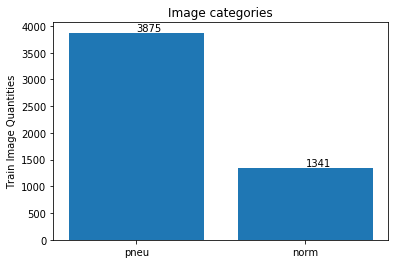

In [122]:


# Load the training files
files_train_sick = glob.glob("/Users/jk/Downloads/chest_Xray/train/PNEUMONIA/*")
files_train_norm = glob.glob("/Users/jk/Downloads/chest_Xray/train/NORMAL/*")
files_test = glob.glob("/Users/jk/Downloads/chest_Xray/test/*/*")

# shuffle
random.shuffle(files_train_sick)
random.shuffle(files_train_norm)
random.shuffle(files_test)


print('We have ', len(files_train_sick) ,' pneumonia train files')
print('We have ', len(files_train_norm) ,' normal train files')

# distrib plot 
x = ('pneu', 'norm')
y = [len(files_train_sick),len(files_train_norm)]
plt.bar(x, height= y)
plt.ylabel('Train Image Quantities')
plt.title('Image categories')
for i, v in enumerate(y):
    plt.text(x[i] , v+30, str(v))
plt.show()

### We make a new training batch with equaly distributed image categories. 
#### Similar quantities of each category will make better training. 

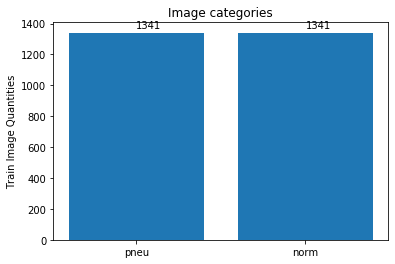

Total images in full equally distributed dataset :  2682
Total images in sample equally distributed dataset :  2682


In [123]:

# get cat with the less images
#TRAIN_SAMPLE_SIZE can at most be twice the val of : min([len(files_train_sick),len(files_train_norm)])


# We will also make a smaller equally distributed dataset for testing purposes
train_subsample_size = int(TRAIN_SAMPLE_SIZE/2)
files_train_sample = files_train_norm[:train_subsample_size] + files_train_sick[:train_subsample_size]
random.shuffle(files_train_sample)


# distrib plot 
x = ('pneu', 'norm')
y = [len(files_train_sick[:train_subsample_size]),len(files_train_norm[:train_subsample_size])]
plt.bar(x, height= y)
plt.ylabel('Train Image Quantities')
plt.title('Image categories')
for i, v in enumerate(y):
    plt.text(x[i] , v+30, str(v))
plt.show()

print('Total images in full equally distributed dataset : ', len(files_train_fullset))
print('Total images in sample equally distributed dataset : ', len(files_train_sample))


### We prepare the data
- We label the datasets using one-hot encoding
- We convert the images to RGB (3channels)
- We resize all images to same pixel height and width values
- We normalize the pixel values for better performance while training



In [124]:


# label , resize and RGB
def fixData(dataset):
    y_data = []
    x_data = []
    for file in dataset:
        image = Image.open(file).convert('RGB')
        image = image.resize((IMG_SIZE, IMG_SIZE))
        data = np.array(image)
        
        x_data.append(data)
        
        if("virus" in file):
            target = 1
        elif("bacteria" in file):
            target = 1
        else:
            target = 0

        y_data.append(target)    
    x_data = np.asarray(x_data)    
    y_data = np.asarray(y_data)
    y_data = to_categorical(y_data,2)
    return (x_data,y_data)


# Training images
(x_train_sample, y_train_sample) = fixData(files_train_sample)

# Testing images
(x_test, y_test) = fixData(files_test)



print("Features train sample shape : ", x_train_sample.shape)
print("Targets train sample shape  : ", y_train_sample.shape)
print("Features test shape : ", x_test.shape)
print("Targets test shape  : ", y_test.shape)


# Normalize data
def normData(data):
    xmax = data.max()
    data = data / xmax
    return data


print('Before normalization : min={}, max={}'.format(x_train_sample.min(), x_train_sample.max()))
x_train_sample = normData(x_train_sample)
x_test = normData(x_test)
print('After normalisation  : min={}, max={}'.format(x_train_sample.min(), x_train_sample.max()))





Features train sample shape :  (2682, 180, 180, 3)
Targets train sample shape  :  (2682, 2)
Features test shape :  (624, 180, 180, 3)
Targets test shape  :  (624, 2)
Before normalization : min=0, max=255
After normalisation  : min=0.0, max=1.0


### Check the Data

#### Here we will display a small sample of our clean dataset


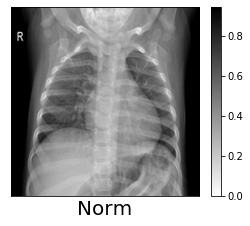

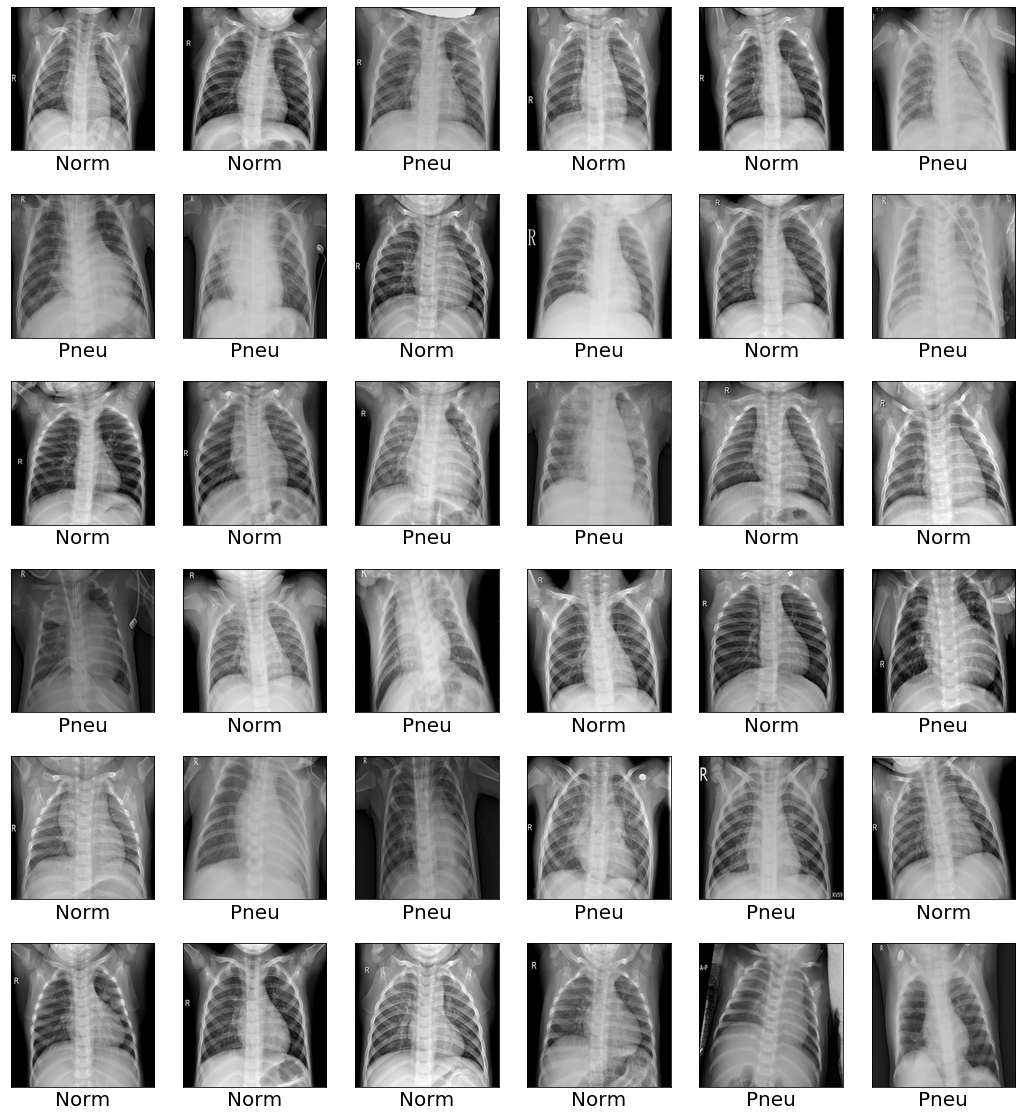

In [125]:


# Targets names for plotting
def targetNames(targets):
    target_names = []
    for target in targets:
        if(target[0] > 0):
            target_names.append("Norm")
        elif(target[1] > 0):
            target_names.append("Pneu")
    return target_names





def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i].any()!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    #save_fig(save_as)
    plt.show()


y_names = targetNames(y_train_sample)

plot_images(x_train_sample, y_names, [48], x_size=5, y_size=5, colorbar=True)
plot_images(x_train_sample, y_names, range(15,51),x_size=3, y_size=3, columns=6)

## Stats...

### The Model

szergzegzergzrgzergez

In [126]:




model = keras.models.Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()





Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 51200)           

## Train the model

In [127]:

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)



history = model.fit(x_train_sample, y_train_sample,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   verbose = 1,
                   validation_data = (x_test, y_test)
                   ,callbacks=[early_stop,PlotLossesKeras()])
                  # )

Epoch 1/2
84/84 [==============================] - 124s 1s/step - loss: 0.7208 - accuracy: 0.5048 - val_loss: 0.3887 - val_accuracy: 0.8189
Epoch 2/2
84/84 [==============================] - 111s 1s/step - loss: 0.3343 - accuracy: 0.8772 - val_loss: 0.6031 - val_accuracy: 0.7756


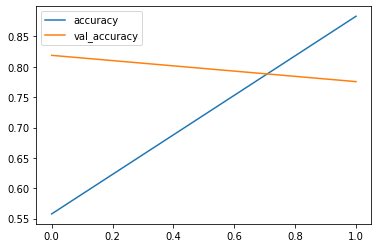

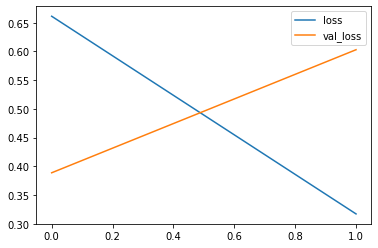

In [129]:
import pandas as pd
metrics = pd.DataFrame(history.history)
metrics.columns
metrics[['accuracy', 'val_accuracy']].plot()

metrics[['loss', 'val_loss']].plot()

##################################### check 69 -> 1:40 for explanations of these plots

In [134]:
#Évaluation du Modèle
model.metrics_names

print(model.metrics_names)
print(model.evaluate(x_test,y_test,verbose=1))






['loss', 'accuracy']
20/20 [==============================] - 6s 313ms/step - loss: 0.6031 - accuracy: 0.7756
[0.603051483631134, 0.7756410241127014]


              precision    recall  f1-score   support

           0       0.82      0.52      0.63       234
           1       0.76      0.93      0.84       390

    accuracy                           0.78       624
   macro avg       0.79      0.72      0.74       624
weighted avg       0.78      0.78      0.76       624



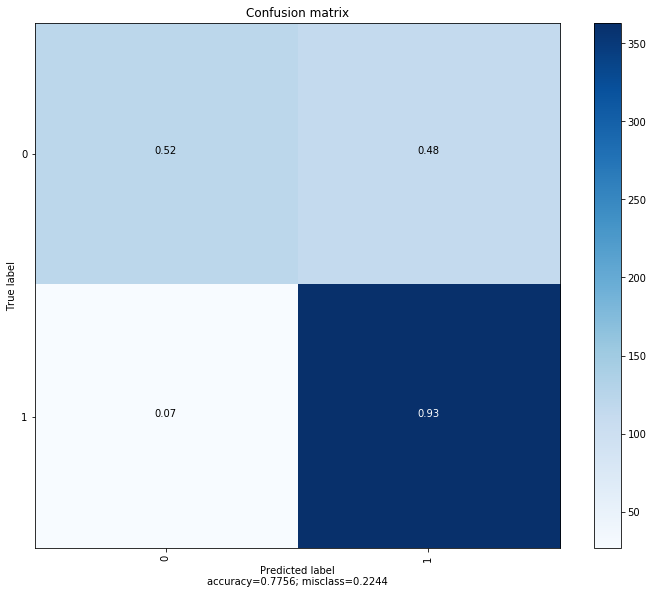

In [131]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools

#put predictions and labels as single digit
predictions = np.argmax(model.predict(x_test), axis=1)
y_test_singleDigit = np.argmax(y_test, axis=1)




def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #save_fig(save_as)
    plt.show()

    
    
    
    
print(classification_report(y_test_singleDigit,predictions))
plot_confusion_matrix(y_test_singleDigit,predictions, range(2), normalize=True)

image single digit label :  1
single digit label predicted by model :  [1]
0 = NORM , 1 = PNEU , pred val ( label val )


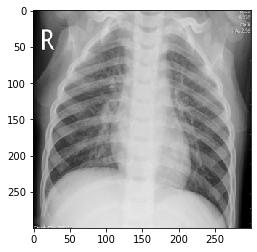

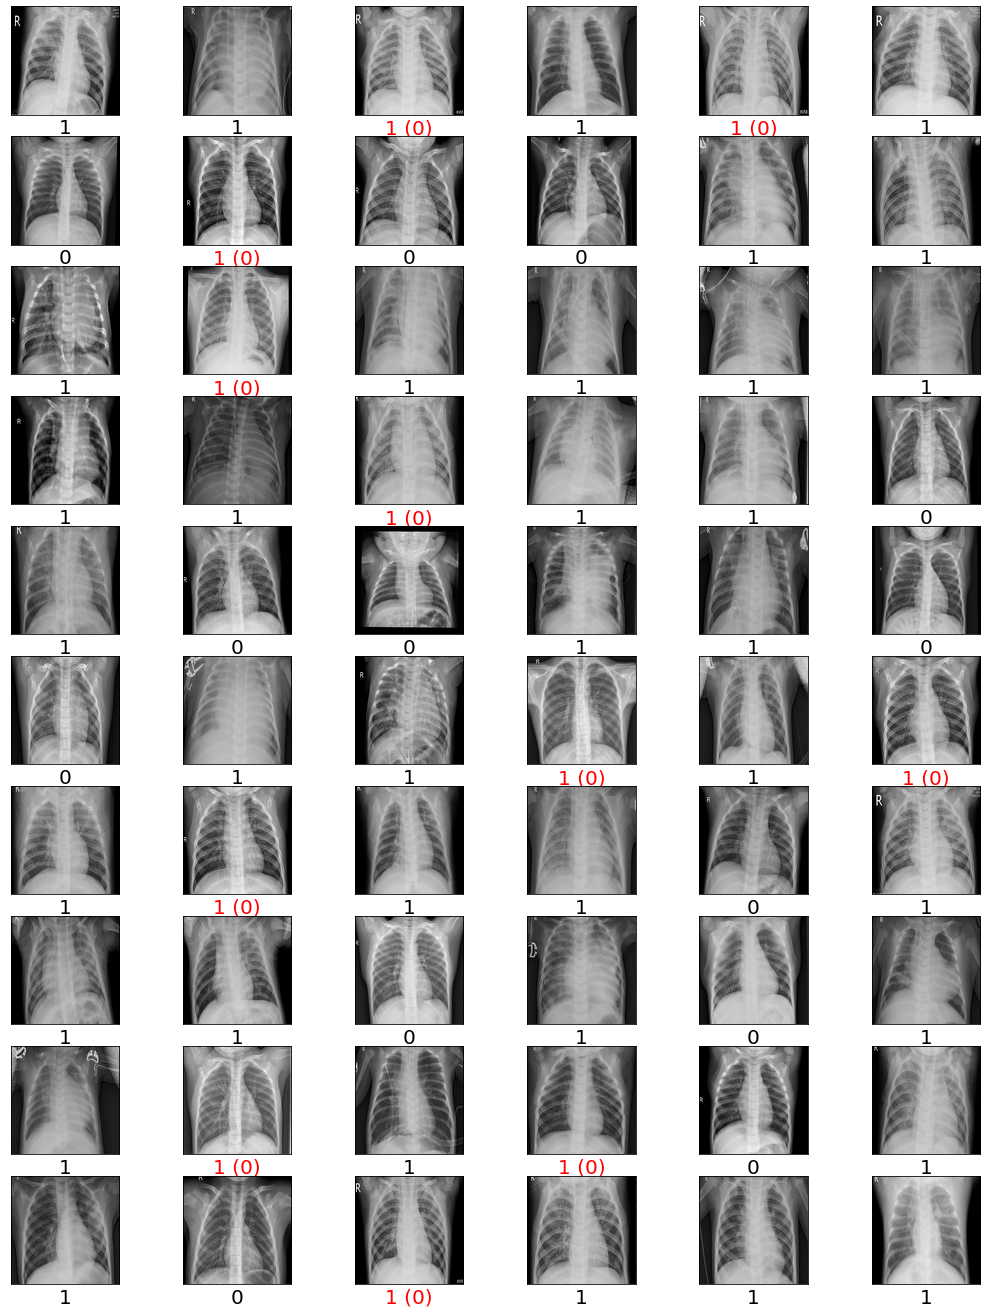

In [101]:
# PLOT SOME RESULTS


my_image = x_test[5]
plt.imshow(my_image)
print('image single digit label : ', y_test_singleDigit[5])
pred = np.argmax(model.predict(my_image.reshape(1,IMG_SIZE,IMG_SIZE,3)), axis=1)
print('single digit label predicted by model : ', pred)


# prediction thumbnails sample
print('0 = NORM , 1 = PNEU , pred val ( label val )') 
y_sigmoid = model.predict(x_test)
y_pred = np.argmax(y_sigmoid, axis=-1)
plot_images(x_test, y_test_singleDigit, range(0,60), columns=6, x_size=3, y_size=2, y_pred=y_pred)

0 = NORM , 1 = PNEU , pred val ( label val )


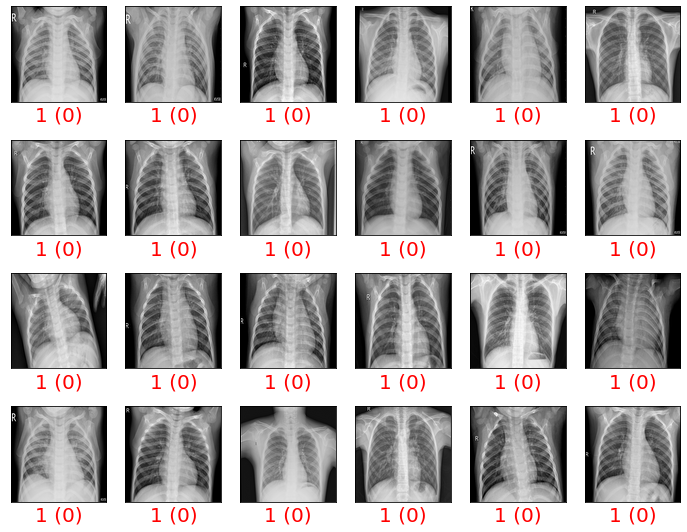

In [102]:
# PLOT SOME ERRORS

print('0 = NORM , 1 = PNEU , pred val ( label val )') 
errors=[ i for i in range(len(x_test)) 
        if y_pred[i]!=y_test_singleDigit[i]]
errors=errors[:min(24, len(errors))]
plot_images(x_test, y_test_singleDigit, errors[:55], 
            columns=6, x_size=2, y_size=2, y_pred=y_pred)